In [1]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


In [2]:
def download_dataset():
  # set up kaggle api and credentials
  ! pip install -q kaggle
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  # download the dataset
  !kaggle datasets download -d 'tanlikesmath/diabetic-retinopathy-resized'
  #unzip
  !mkdir diabetic-retinopathy-resized
  !unzip diabetic-retinopathy-resized.zip -d diabetic-retinopathy-resized
  !mv ./* diabetic-retinopathy-resized

In [ ]:
import os
dataset_dir_exist = os.path.isdir('diabetic-retinopathy-resized')
if not dataset_dir_exist:
  print('downloading dataset')
  download_dataset()


Mount google drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/4380_left.jpeg


(1024, 1024)

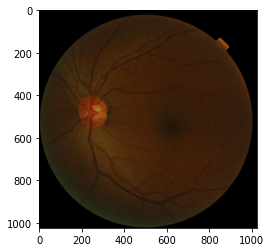

In [5]:
image_fullset = pd.read_csv("./diabetic-retinopathy-resized/trainLabels_cropped.csv")
images_path = "./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped"
img_path = os.path.join(images_path, image_fullset.iloc[3500].image+".jpeg")
print(img_path)
img = Image.open(img_path)
plt.imshow(img)
img.size

In [6]:
print(image_fullset.groupby('level').size())

level
0    25802
1     2438
2     5288
3      872
4      708
dtype: int64


In [7]:
# trying to balancing the data by oversampling the minority
def over_sample(input_df):
    num_samples_in_class = input_df.groupby('level')
    max_sample_size = num_samples_in_class.size().max()
    df_out = input_df.copy()
    for level, group_df in num_samples_in_class:
        num_sample = group_df.count()[0]
        if num_sample == max_sample_size:
            continue
        # number of copies to make for each class
        oversampling_multiplier = int(max_sample_size / num_sample) - 1
        is_level = input_df['level'] == level
        df_level = input_df[is_level]
        df_out = df_out.append([df_level]*oversampling_multiplier, ignore_index=True)
    print(df_out.groupby('level').size())
    return df_out

In [8]:
tmp_df = over_sample(image_fullset)
print(tmp_df.groupby('level').size())

level
0    25802
1    24380
2    21152
3    25288
4    25488
dtype: int64
level
0    25802
1    24380
2    21152
3    25288
4    25488
dtype: int64


In [9]:
class convert_to_grey(object):
    def __call__(self, img):
        """
        :param img: PIL): Image 

        :return: greyscale image with weight
        """
        image = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (image.shape[0], image.shape[0]))
        image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , image.shape[0]/10) ,-4 ,128) # the trick is to add this line
        # work around: need to copy values for the third dimension, so that it can use InceptionV3 pretrain model
        return np.repeat(image[..., np.newaxis], 3, -1)
       

In [10]:
import torchvision.transforms as transforms
train_transform = transforms.Compose([
    transforms.Resize((299,299)),
    #transforms.Resize((800,800)),
    # augmentation
    #convert_to_grey(),
    transforms.ToTensor(),

    # below doesn't perform well
    # transforms.RandomResizedCrop((299,299)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((299,299)),
    #transforms.Resize((800,800)),

    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])


In [14]:
import torch

# custom dataloader
class retinaDataset(Dataset):
    def __init__(self, transform, data_frame, imagepath="./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped", total=None):
        
        self.df = data_frame
    
        if (total is not None):
            self.df = self.df[:total]
        
        self.transform = transform
        self.imagepath = imagepath
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.imagepath, self.df.iloc[index].image +".jpeg")
        img = Image.open(img_path)
        
        if(self.transform):
            img = self.transform(img)
        
        return img, torch.tensor(self.df.iloc[index].level)


In [43]:
num_classes = 5
load_checkpoint = True
use_over_sample = False
# hyperparameter
learning_rate = 1e-4
num_epochs = 50
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_load_dir = "/content/gdrive/My Drive/543_final_project_files/higher_res/epoch_15"
checkpoint_save_dir =  "/content/gdrive/My Drive/543_final_project_files/higher_res/more_epoch"

In [44]:
from torchvision.models import inception_v3

model = inception_v3(pretrained=True)

# whether to use the auxillary output
use_aux = True

# fine tuning entire model
for param in model.parameters():
    param.requires_grad = False
    
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [45]:
model.fc = torch.nn.Linear(in_features=2048, out_features=5, bias=True)

# linear layer aux output
if use_aux:
  num_ftrs = model.AuxLogits.fc.in_features
  model.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
else:
  model.aux_logits = False

model = model.to(device=device)
#model

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

In [49]:
# load checkpoint
dataloaders = None
epoch = 0
losses_train = []
accs_train = []
losses_val = []
accs_val = []

if load_checkpoint:
  model, optimizer, epoch, loss, dataloaders, losses_train, accs_train, losses_val, accs_val  = load_model(checkpoint_load_dir, model, optimizer)

In [48]:
if not load_checkpoint:
  # train:validation:test: 7:2:1
  shuffle_dataset = True
  random_seed= 40

  # Creating data indices for training and validation splits:
  dataset_size = image_fullset.count()[0]
  print(dataset_size)
  indices = list(range(dataset_size))

  train_split, val_split = 0.7, 0.9
  train_split_point_idx = int(np.floor(train_split * dataset_size))
  val_split_point_idx = int(np.floor(val_split * dataset_size))

  if shuffle_dataset :
      np.random.seed(random_seed)
      np.random.shuffle(indices)
  train_indices, val_indices, test_indices = indices[:train_split_point_idx], \
                                            indices[train_split_point_idx:val_split_point_idx], \
                                            indices[val_split_point_idx:]
  print(len(train_indices), len(val_indices), len(test_indices))
  # Creating PT data samplers and loaders:
  train_sampler = SubsetRandomSampler(train_indices)
  valid_sampler = SubsetRandomSampler(val_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  # Load images. The two dataset is the same except for the transformation applied
  
  # optionally, oversample the training data
  train_set = image_fullset.iloc[train_indices]
  if use_over_sample:
      train_set = over_sample(train_set)

  train_dataset = retinaDataset(transform=train_transform, data_frame=train_set, total=None)
  valid_and_test_dataset = retinaDataset(test_transform, data_frame=image_fullset, total=None)

  train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)
  validation_dataloader = DataLoader(dataset=valid_and_test_dataset, batch_size=batch_size, sampler=valid_sampler)
  test_dataloader = DataLoader(dataset=valid_and_test_dataset, batch_size=batch_size, sampler=test_sampler)

  dataloaders = {'train': train_dataloader, 'val': validation_dataloader, 'test': test_dataloader}
  print(len(train_dataloader))

In [ ]:
for epoch in range(epoch, num_epochs):
    # training and validation phases for each epoch
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0
        # iterate over batches
        for data, target in tqdm(dataloaders[phase]):
            data = data.to(device=device)
            target = target.to(device=device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                if use_aux and phase == 'train':
                    score, aux_outputs = model(data)
                    loss1 = loss_criterion(score, target)
                    loss2 = loss_criterion(aux_outputs, target)
                    loss = loss1 + 0.4*loss2
                else:
                    score = model(data)
                    loss = loss_criterion(score, target)

                # get predicted classes
                _, preds = torch.max(score, 1)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # record loss
                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(preds == target.data)

        epoch_loss = running_loss / (len(dataloaders[phase]) * batch_size)
        epoch_acc = 100 * running_corrects.double() / (len(dataloaders[phase]) * batch_size)
        print(f"for epoch {epoch}, {phase} loss : {epoch_loss}, {phase} accuracy: {epoch_acc}")
        if phase == 'train':
            losses_train.append(epoch_loss)
            accs_train.append(epoch_acc)
        else:
            losses_val.append(epoch_loss)
            accs_val.append(epoch_acc)
        # save the model every 1 epochs
        #if epoch % 1 == 0:
        print("saving model")
        save_model(checkpoint_save_dir)

  6%|▌         | 45/768 [01:17<20:01,  1.66s/it]

In [ ]:
# loss curve
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='validation')
plt.legend()
plt.show()

# accuracy curve
plt.plot(accs_train, label='train')
plt.plot(accs_val, label='validation')
plt.legend()
plt.show()

In [31]:
def evaluate_model(model, loader):
    model.eval()
    
    correct_output = 0
    total_output = 0
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            
            score = model(x)
            _,predictions = score.max(1)
            
            correct_output += (y==predictions).sum()
            total_output += predictions.shape[0]
    model.train()
    print(f"out of {total_output} , total correct: {correct_output} with an accuracy of {float(correct_output/total_output)*100}")

In [32]:
# get accuracy on test set
evaluate_model(model, dataloaders['test'])

100%|██████████| 110/110 [02:17<00:00,  1.25s/it]


out of 3511 , total correct: 2576 with an accuracy of 73.3694076538086


In [38]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [39]:
# get all predictions to plot metrics and ROC curve
y_true, y_pred, y_pred_prob = pytorch_predict(model, dataloaders['test'], device)

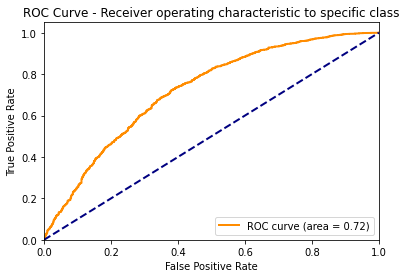

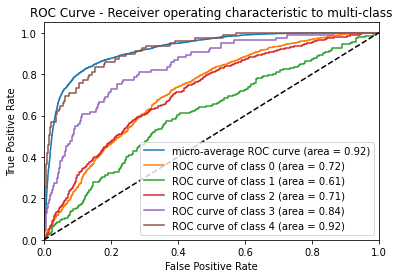

In [40]:
y_true_category = to_categorical(y_true, 5)
plotROC(y_pred_prob, y_true_category)

In [41]:
plotTables(y_pred_prob, y_true_category)

Groud Truth values:  (3511, 5)
[[1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]]
----------------------------------------
Predicted values:  (3511, 5)
[[0.73048437 0.05246339 0.1620714  0.04089062 0.01409021]
 [0.73083925 0.09469201 0.1551425  0.01515788 0.0041684 ]
 [0.7437964  0.03063457 0.19491783 0.0187788  0.01187241]
 ...
 [0.58383936 0.07725065 0.2521574  0.05859184 0.02816079]
 [0.698256   0.08298088 0.18501882 0.02882036 0.00492388]
 [0.84082246 0.05866538 0.09180452 0.00601337 0.00269433]]
2576
 
+---------------------------------+--------------------+
| Inceptionv3 Performance Metrics |         %          |
+---------------------------------+--------------------+
|            Accuracy             | 0.7336941042438052 |
|            Precision            |  0.60107329250022  |
|      Recall/Sensitivity         | 0.7336941042438052 |
|            F1_score             | 0.6283086611167944 |
+---------------------------------+--------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: 

In [34]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from prettytable import PrettyTable

# plot ROC curve 
def plotROC(y_pred, y_test): 
    # Plotting ROC curve
    y = y_test
    # Binarize the output
    y = label_binarize(y, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC for specific class
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to specific class')
    plt.legend(loc="lower right")
    plt.show()
    
    print(' ')
    
    # Plot ROC curve for multi class
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [35]:
def plotTables(y_pred, y_test): 
    print("Groud Truth values: ",y_test.shape)
    print(y_test)
    print('-'*40)
    print("Predicted values: ",y_pred.shape)
    print(y_pred)
    pred = np.argmax(y_pred, axis=1)
    test = np.argmax(y_test, axis=1)
    print(np.sum(pred == test))
    accuracy = (np.sum(np.argmax(y_pred, 1) == np.argmax(y_test,1))/y_test.shape[0])
    precision = metrics.precision_score(test, pred,average='weighted')
    recall = metrics.recall_score(test, pred,average='weighted')
    f1 = metrics.f1_score(test, pred,average='weighted')
    print(" ")
    Cnn_Table = PrettyTable(['Inceptionv3 Performance Metrics', '%'])

    # Add rows
    Cnn_Table.add_row(['Accuracy ',accuracy])
    Cnn_Table.add_row(['Precision',precision])
    Cnn_Table.add_row(['Recall/Sensitivity   ',recall])
    Cnn_Table.add_row(['F1_score ',f1])

    print(Cnn_Table)

    #Confusion Matrix
    print(" ")
    matrix = metrics.confusion_matrix(test, pred)
    print(" ")
    print('inception_v3_Confusion_Matrix:')
    print(" ")
    print(matrix)
    print(" ")
    
    print("classification_report: ")
    print('-'*40)
    print(metrics.classification_report(test, pred))

In [36]:
import torch.nn.functional as F

def pytorch_predict(model, test_loader, device):
    '''
    Make prediction from a pytorch model
    '''
    # set model to evaluate model
    model.eval()
    
    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)
    
    # deactivate autograd engine and reduce memory usage and speed up computations
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)
    
    y_true = y_true.cpu().numpy()  
    _, y_pred = torch.max(all_outputs, 1)
    y_pred = y_pred.cpu().numpy()
    y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
    model.train()

    return y_true, y_pred, y_pred_prob

In [51]:
# change current working directory for output
def save_model(output_dir):
  os.chdir(output_dir)
  os.makedirs('./{}/'.format(epoch), exist_ok = True)
  torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              'train_dataloader': dataloaders['train'],
              'val_dataloader': dataloaders['val'],
              'test_dataloader': dataloaders['test'],
              'losses_train': losses_train,
              'accs_train': accs_train,
              'losses_val': losses_val,
              'accs_val': accs_val}, f'./{epoch}/model.checkpoint')

  # change the wd back
  os.chdir("/content/")

In [50]:
# loading model
def load_model(checkpoint_dir, model, optimizer, mode='train'):
  os.chdir(checkpoint_dir)
  checkpoint = torch.load('model.checkpoint')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  # load dataloaders  
  train_loader = checkpoint['train_dataloader']
  val_loader = checkpoint['val_dataloader']
  test_loader = checkpoint['test_dataloader']
  dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
  
  # load curve metrics
  losses_train = checkpoint['losses_train']
  accs_train = checkpoint['accs_train']
  losses_val = checkpoint['losses_val']
  accs_val = checkpoint['accs_val']

  if mode == 'train':
    model.train()
  else:
    model.eval()
  # change the wd back
  os.chdir("/content/")
  return model, optimizer, epoch, loss, dataloaders, losses_train, accs_train, losses_val, accs_val